# **YOLO TEST**


## **1. Setup Environment**

In [3]:
# @title **1.1 GitHub Clone**
!git clone https://github.com/SamueleReale00/6d_pose_estimation.git
%cd 6d_pose_estimation
!pip install -r requirements.txt  # <--- Automatically installs everything above

Cloning into '6d_pose_estimation'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 29 (delta 4), reused 20 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (29/29), 12.85 KiB | 526.00 KiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/6d_pose_estimation
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.9 MB/s eta 0:00:00


In [8]:
# @title **1.2 Dataset download**
# 1. Install YOLO library
#%pip install ultralytics -q

# 2. Setup Imports so Python finds your 'dataset' folder
import sys
import os
sys.path.append('/content/6d_pose_estimation')

# 3. Import your modules
from dataset import download_dataset, MultiObjectLineModDataset
from torchvision import transforms
import shutil
import numpy as np
from tqdm import tqdm

# 4. Ensure data is present
new_link="https://drive.google.com/file/d/1tGgciXm7r4K6kBW1iqLxDBJ3ffKgISje/view?usp=drive_link"
download_dataset(url=new_link) # This handles the download if missing

⬇️ Dataset not found. Downloading from: https://drive.google.com/file/d/1tGgciXm7r4K6kBW1iqLxDBJ3ffKgISje/view?usp=drive_link


Downloading...
From (original): https://drive.google.com/uc?id=1tGgciXm7r4K6kBW1iqLxDBJ3ffKgISje
From (redirected): https://drive.google.com/uc?id=1tGgciXm7r4K6kBW1iqLxDBJ3ffKgISje&confirm=t&uuid=b8c9ebd3-3096-4842-b2ee-d2aff281a915
To: /content/datasets/linemod/Linemod_preprocessed.zip
100%|██████████| 8.97G/8.97G [02:31<00:00, 59.2MB/s]


📦 Extracting zip file...
✅ Success! Data located at: /content/datasets/linemod


## **2. Convert Data to YOLO Format**

<details>
  <summary><strong>Explaination</strong></summary>

# 🔄 Phase 2: Data Conversion (LineMOD to YOLO)

## 1. The Objective
We need to train a standard **YOLOv8** model using the **LineMOD** dataset.
However, standard YOLO libraries (like `ultralytics`) cannot read our custom `MultiObjectLineModDataset` class or the raw `gt.yml` files. They expect data in a very specific folder structure and text format.

**Goal:** Write a script that acts as a "Translator," determining where every object is and rewriting that information in the language YOLO understands.

---

## 2. The Format Gap (The "Why")

We cannot use the raw data directly because of these critical differences:

| Feature | **Raw LineMOD Data** | **YOLO Requirement** |
| :--- | :--- | :--- |
| **File Storage** | Images and labels separated in `01`, `02` folders. | All images in one folder; all text labels in another. |
| **Label File** | One giant `gt.yml` file per object folder. | One distinct `.txt` file **per image**. |
| **Coordinates** | **Top-Left** corner $(x, y)$ in **Pixels**. | **Center** point $(c_x, c_y)$ in **Normalized** $(0.0 - 1.0)$ values. |
| **Class IDs** | 1-based integers (1 = Ape, 2 = Can...). | 0-based index (0 = First Class, 1 = Second...). |

---

## 3. The Pipeline Steps (The "What")

The conversion script performs five logical operations for every single image in the dataset:

### Step A: Directory Setup
YOLO requires a rigid folder structure to separate Training (learning) data from Validation (testing) data.
* **Action:** The script creates `/content/yolo_dataset/train/images`, `/content/yolo_dataset/train/labels`, and the equivalent `val` folders.

### Step B: Loading
* **Action:** We initialize our `MultiObjectLineModDataset`.
* **Why:** Instead of writing new complex code to parse YAML files again, we re-use the robust logic we already built. We let the dataset class hand us the `bbox` and `obj_id` easily.

### Step C: Mathematical Transformation
This is the core logic. We convert the pixel numbers.
* **Input:** $x_{min}, y_{min}, w, h$ (from `gt.yml`)
* **Image Size:** $W_{img}, H_{img}$ (640, 480)
* **Formulas:**
    1.  **Find Center:** $x_{center} = x_{min} + (w / 2)$
    2.  **Normalize Width:** $w_{norm} = w / W_{img}$
    3.  **Normalize Center:** $cx_{norm} = x_{center} / W_{img}$
    *(Repeat for Y/Height)*

### Step D: Class Mapping
* **Input:** Object ID `1` (Ape).
* **Logic:** YOLO classes must start at 0.
* **Action:** We simply subtract 1. ($1 \rightarrow 0$).

### Step E: Splitting (Train vs. Val)
We need to save about 80% of images for training and 20% for validation.
* **Logic:** We use a **Deterministic Hash** on the file name.
* **Why:** If we used `random.choice()`, running the script twice might move an image from Train to Val, causing "Data Leakage" (cheating). Hashing ensures `Image_0055` *always* goes to the same folder every time we run the script.

---

## 4. The Output Structure

After running the script, your data transforms from the "Source" structure to the "Target" structure:

**Source (LineMOD):**
```text
data/
  ├── 01/
  │   ├── rgb/0000.png
  │   └── gt.yml
  └── 02/ ...
```

---

## 5. YOLO Data Structure Explained

You noticed a difference between the **filename** and the **file content**. This separation is intentional and necessary.

### 1. The Filename (`01_0000.txt`)
* **Format:** `{obj_id}_{img_id}.txt` (e.g., `01` for Ape, `05` for Can).
* **Why:** This guarantees **uniqueness**.
    * Object 1 has an image `0000.png`.
    * Object 5 also has an image `0000.png`.
    * If we just named them `0000.txt`, one would overwrite the other. Using the Object ID in the name (`01_0000`, `05_0000`) prevents data loss.
* **Note:** YOLO **ignores** filenames. It doesn't care what you call them.

### 2. The File Content (`0 0.5 ...`)
* **Format:** `{class_id} {x} {y} {w} {h}`.
* **Why:** This is for **Training**.
    * YOLO algorithms require class labels to be **0-indexed integers** (0, 1, 2...).
    * We calculate `class_id = obj_id - 1` so that Ape (ID 1) becomes Class 0, matching the `linemod.yaml` config.

**Summary:**
* **Filename** is for **File System Organization** (avoiding overwrites).
* **Content** is for **Neural Network Logic** (correct class indices).

### 3. The Case of the Missing Object 3

Since the folder `/data/03/` does not exist, the `obj_id = 3` is simply **skipped** by your dataset loader.

### 1. The Calculation
Your script calculates the YOLO class using:  
`class_id = obj_id - 1`  
So, Object 3 would have been **YOLO Class 2**.

### 2. The Result
* **Class 0 (Ape):** Has thousands of labels.
* **Class 1 (Benchvise):** Has thousands of labels.
* **Class 2 (Bowl):** **Has exactly 0 labels.**
* **Class 3 (Can):** Has thousands of labels.

### 3. Effect on Training
The model still "knows" Class 2 exists (because it is in your `linemod.yaml`), but since it **never sees an example** of it during training, it will simply **never predict it**. It does not break the model; it just creates a "silent" class.

</details>

In [9]:
# @title **2.1 Dataset conversion to YOLO**

# --- CONFIGURATION ---
# This matches where download_dataset() puts the files
ROOT_DATA = "/content/datasets/linemod/Linemod_preprocessed/data"
OUTPUT_DIR = "/content/yolo_dataset"
TRAIN_SPLIT = 0.8  # 80% Train, 20% Validation

# 1. Setup Folders
import os
import shutil
from tqdm import tqdm
import numpy as np

for split in ['train', 'val']:
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'images'), exist_ok=True)
    os.makedirs(os.path.join(OUTPUT_DIR, split, 'labels'), exist_ok=True)

# 2. Initialize your Dataset
# We use your custom class to read the data cleanly
print("Loading dataset for conversion...")
dataset = MultiObjectLineModDataset(root_dir=ROOT_DATA, transform=None)

print(f"Converting {len(dataset)} samples to YOLO format...")

# 3. Loop and Convert
for i in tqdm(range(len(dataset))):
    sample = dataset[i]

    # Extract Info
    img_path = sample['image_path']
    bbox = sample['bbox'] # [x, y, w, h] pixels
    obj_id = sample['obj_id'] # LineMOD ID (e.g. 1 for Ape)
    img_id = sample['image_id']

    # Read image dimensions (Height, Width) from the tensor
    c, h_img, w_img = sample['image'].shape

    # --- MATH: Convert Pixel Box to YOLO Normalized Center ---
    # YOLO format: class_id x_center y_center width height (all 0.0 to 1.0)
    x, y, w, h = bbox

    cx = (x + w / 2) / w_img
    cy = (y + h / 2) / h_img
    nw = w / w_img
    nh = h / h_img

    # Map Class ID: LineMOD is 1-15. YOLO must start at 0.
    class_id = obj_id - 1

    # --- SPLIT: Randomly decide if Train or Val ---
    # We use a deterministic hash so the split is consistent if you re-run
    split = 'train' if (hash(f"{obj_id}_{img_id}") % 100) < (TRAIN_SPLIT * 100) else 'val'

    # --- SAVE FILES ---
    # We use unique names to avoid overwriting (01_0000, 02_0000...)
    unique_name = f"{obj_id:02d}_{img_id:04d}"

    # A. Copy Image
    dest_img_path = os.path.join(OUTPUT_DIR, split, 'images', f"{unique_name}.png")
    shutil.copy(img_path, dest_img_path)

    # B. Write Label File
    label_path = os.path.join(OUTPUT_DIR, split, 'labels', f"{unique_name}.txt")
    with open(label_path, 'w') as f:
        f.write(f"{class_id} {cx:.6f} {cy:.6f} {nw:.6f} {nh:.6f}")

print(f"\nConversion Complete! Data ready in {OUTPUT_DIR}")

Loading dataset for conversion...
Scanning dataset folders...
Loading Object 01...
Loading Object 02...
Loading Object 04...
Loading Object 05...
Loading Object 06...
Loading Object 08...
Loading Object 09...
Loading Object 10...
Loading Object 11...
Loading Object 12...
Loading Object 13...
Loading Object 14...
Loading Object 15...
Converting 15800 samples to YOLO format...


100%|██████████| 15800/15800 [06:00<00:00, 43.80it/s]


Conversion Complete! Data ready in /content/yolo_dataset


🔍 Verifying data in: /content/yolo_dataset

--- TRAIN SPLIT ---
Images: 11752
Labels: 11752
Checking sample: 09_0512.png
Label content: 8 0.347656 0.472917 0.064062 0.108333
✅ Coordinates look normalized.


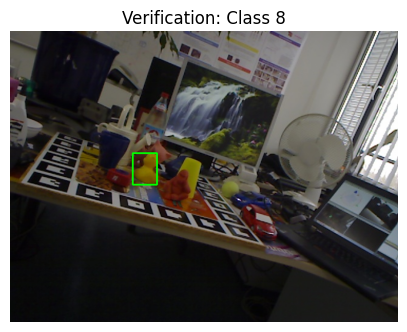


--- VAL SPLIT ---
Images: 2878
Labels: 2878
Checking sample: 08_0308.png
Label content: 7 0.436719 0.444792 0.282813 0.302083
✅ Coordinates look normalized.


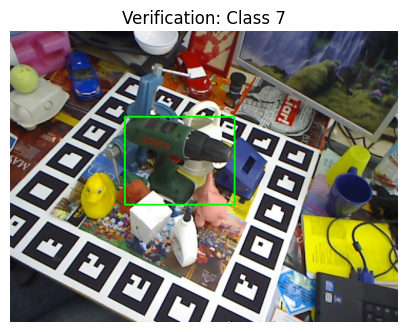

In [10]:
# @title **2.2 YOLO Dataset check**

import cv2
import matplotlib.pyplot as plt
import glob
import os

def verify_yolo_data(base_dir="/content/yolo_dataset"):
    print(f"🔍 Verifying data in: {base_dir}")

    for split in ['train', 'val']:
        img_dir = os.path.join(base_dir, split, 'images')
        lbl_dir = os.path.join(base_dir, split, 'labels')

        # 1. Count Files
        images = sorted(glob.glob(os.path.join(img_dir, "*.png"))) + \
                 sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
        labels = sorted(glob.glob(os.path.join(lbl_dir, "*.txt")))

        print(f"\n--- {split.upper()} SPLIT ---")
        print(f"Images: {len(images)}")
        print(f"Labels: {len(labels)}")

        if len(images) == 0:
            print("❌ Error: No images found!")
            continue

        if len(images) != len(labels):
            print("⚠️ Warning: Mismatch between images and labels count.")

        # 2. Inspect One Random Sample
        import random
        sample_img_path = random.choice(images)
        sample_lbl_path = sample_img_path.replace("images", "labels").replace(".png", ".txt").replace(".jpg", ".txt")

        if not os.path.exists(sample_lbl_path):
            print(f"❌ Error: Label missing for {sample_img_path}")
            continue

        # Read Label
        with open(sample_lbl_path, 'r') as f:
            lines = f.readlines()

        print(f"Checking sample: {os.path.basename(sample_img_path)}")
        print(f"Label content: {lines[0].strip()}") # Show first line

        # Parse Coordinates
        cls_id, cx, cy, w, h = map(float, lines[0].split())

        # Check Normalization
        if not (0 <= cx <= 1 and 0 <= cy <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
            print("❌ Error: Coordinates are NOT normalized (must be 0-1).")
        else:
            print("✅ Coordinates look normalized.")

        # 3. Visualize
        img = cv2.imread(sample_img_path)
        h_img, w_img, _ = img.shape

        # Un-normalize
        x_center = cx * w_img
        y_center = cy * h_img
        width = w * w_img
        height = h * h_img

        x_top = int(x_center - (width / 2))
        y_top = int(y_center - (height / 2))
        x_bot = int(x_center + (width / 2))
        y_bot = int(y_center + (height / 2))

        # Draw
        cv2.rectangle(img, (x_top, y_top), (x_bot, y_bot), (0, 255, 0), 2)

        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Verification: Class {int(cls_id)}")
        plt.axis('off')
        plt.show()

# Run the verification
verify_yolo_data()

In [11]:
# @title **2.3 Saving YOLO dataset on Drive**

import shutil
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION ---
# The folder created by your previous step
source_folder = "/content/yolo_dataset"
# Where you want it on Drive
drive_dest_dir = "/content/drive/MyDrive/AML/6d_pose_project/datasets"
zip_filename = "yolo_dataset_ready.zip"

# 2. Create the destination folder in Drive if it doesn't exist
os.makedirs(drive_dest_dir, exist_ok=True)

# 3. Zip the folder (Fastest way)
# We store the zip temporarily in Colab
temp_zip_path = f"/content/{zip_filename}"

print(f"📦 Zipping '{source_folder}'... (This keeps Google Drive happy)")
# -r = recursive, -q = quiet
!zip -r -q {temp_zip_path} {source_folder}

# 4. Copy the Zip to Drive
final_path = os.path.join(drive_dest_dir, zip_filename)
print(f"🚀 Uploading to Drive: {final_path}...")
shutil.copy(temp_zip_path, final_path)

print("✅ Dataset saved! You can now load it directly from Drive next time.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Zipping '/content/yolo_dataset'... (This keeps Google Drive happy)
🚀 Uploading to Drive: /content/drive/MyDrive/AML/6d_pose_project/datasets/yolo_dataset_ready.zip...
✅ Dataset saved! You can now load it directly from Drive next time.


# **3. YOLO Finetuning**

In [60]:
# @title **3.1 Yaml configuration file**

import yaml

# CORRECTED Configuration based on your folder structure
config = {
    'path': '/content/yolo_dataset',
    'train': 'train/images',
    'val': 'val/images',
    'names': {
        0: 'Ape',
        1: 'Benchvise',
        2: 'Bowl',        # Missing folder 03
        3: 'Cam',
        4: 'Can',         # This is the "Waterer" (Red can)
        5: 'Cat',
        6: 'Cup',         # Missing folder 07
        7: 'Driller',
        8: 'Duck',
        9: 'Eggbox',
        10: 'Glue',
        11: 'Holepuncher',
        12: 'Iron',
        13: 'Lamp',
        14: 'Phone'
    }
}

with open('/content/linemod.yaml', 'w') as f:
    yaml.dump(config, f)

print("✅ linemod.yaml corrected! Run inference again to see correct labels.")

✅ linemod.yaml corrected! Run inference again to see correct labels.


In [63]:
# @title **3.2 Translation dictionary fix**

import torch
import os

# 1. Define the Correct Class Mapping
correct_names = {
    0: 'Ape',
    1: 'Benchvise',
    2: 'Bowl',        # Placeholder
    3: 'Cam',         # Corrected
    4: 'Can',         # Corrected
    5: 'Cat',         # Corrected
    6: 'Cup',         # Placeholder
    7: 'Driller',
    8: 'Duck',
    9: 'Eggbox',
    10: 'Glue',
    11: 'Holepuncher',
    12: 'Iron',
    13: 'Lamp',
    14: 'Phone'
}

# 2. Define Directory
weights_dir = '/content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs/run_safe_01/weights'
files_to_fix = ['best.pt', 'last.pt']

print(f"🔧 Fixing metadata in: {weights_dir}...\n")

for filename in files_to_fix:
    full_path = os.path.join(weights_dir, filename)

    if os.path.exists(full_path):
        print(f"Processing {filename}...")

        try:
            # A. Load the raw checkpoint
            # FIX: We add 'weights_only=False' to tell PyTorch we trust this file
            ckpt = torch.load(full_path, map_location='cpu', weights_only=False)

            # B. Access the internal model object and update names
            # In YOLOv8, ckpt['model'] is the actual PyTorch Model object
            if hasattr(ckpt['model'], 'names'):
                ckpt['model'].names = correct_names

                # C. Save it back
                torch.save(ckpt, full_path)
                print(f"✅ Successfully patched {filename}")
            else:
                print(f"⚠️ Could not find 'names' attribute in {filename}")

        except Exception as e:
            print(f"❌ Error fixing {filename}: {e}")

    else:
        print(f"⚠️ File not found: {filename}")

print("\n🎉 All weights updated! You can now load them normally.")

🔧 Fixing metadata in: /content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs/run_safe_01/weights...

Processing best.pt...
✅ Successfully patched best.pt
Processing last.pt...
✅ Successfully patched last.pt

🎉 All weights updated! You can now load them normally.


In [65]:
# @title **3.3 Check the fix**
from ultralytics import YOLO

# 1. Load your saved model from Drive
model = YOLO('/content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs/run_safe_01/weights/last.pt')

# 2. Print the internal dictionary
print("Current Model Classes:")
print(model.names)

# 3. Automatic Check
if model.names[5] == 'Cat' and model.names[3] == 'Cam':
    print("\n✅ SUCCESS: The model file is permanently fixed!")
else:
    print("\n❌ FAILURE: The model still has the old labels.")

Current Model Classes:
{0: 'Ape', 1: 'Benchvise', 2: 'Bowl', 3: 'Cam', 4: 'Can', 5: 'Cat', 6: 'Cup', 7: 'Driller', 8: 'Duck', 9: 'Eggbox', 10: 'Glue', 11: 'Holepuncher', 12: 'Iron', 13: 'Lamp', 14: 'Phone'}

✅ SUCCESS: The model file is permanently fixed!


In [ ]:
# @title **3.4 Drive mount**
from google.colab import drive
import os

drive.mount('/content/drive')

# DEFINITION (Source of Truth)
# We define the variable here and will use 'TRAINING_ROOT' in the next cell
TRAINING_ROOT = '/content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs'

# Create the folder immediately so we know permissions work
os.makedirs(TRAINING_ROOT, exist_ok=True)
print(f"📂 Training directory ready at: {TRAINING_ROOT}")

In [ ]:
# @title **3.5 YOLO finetuning**

from ultralytics import YOLO
import os

resumeTraining = False

# Use the variable from Cell 3.2 (No re-typing the string!)
project_dir = TRAINING_ROOT
run_name = 'run_safe_01'

# Path construction is cleaner now
checkpoint_path = os.path.join(project_dir, run_name, 'weights/last.pt')

if resumeTraining and os.path.exists(checkpoint_path):
    print(f"🔄 Resuming training from: {checkpoint_path}")
    model = YOLO(checkpoint_path)
    model.train(resume=True)
else:
    print("🚀 Starting FRESH training...")
    model = YOLO('yolov8n.pt')

    model.train(
        data='/content/linemod.yaml',
        epochs=50,
        imgsz=640,
        batch=16,
        project=project_dir,  # Uses the path defined in 3.2
        name=run_name
    )

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/linemod.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, k

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x78f760c7be00>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.04504

# **4. YOLO Result**

How to read the graph:

    1.  mAP50 (Mean Average Precision): This line should go UP.
        If it reached 0.8 or 0.9 (80-90%) and flattened out,
        the model is excellent.
    2.  Box Loss: This line should go DOWN.
    3.  Do you need to train more? If the mAP line was still climbing
        steeply at Epoch 50, yes (train more).
        If it was flat for the last 10 epochs, no (you are done).

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📈 Training Results (Loss & Accuracy):


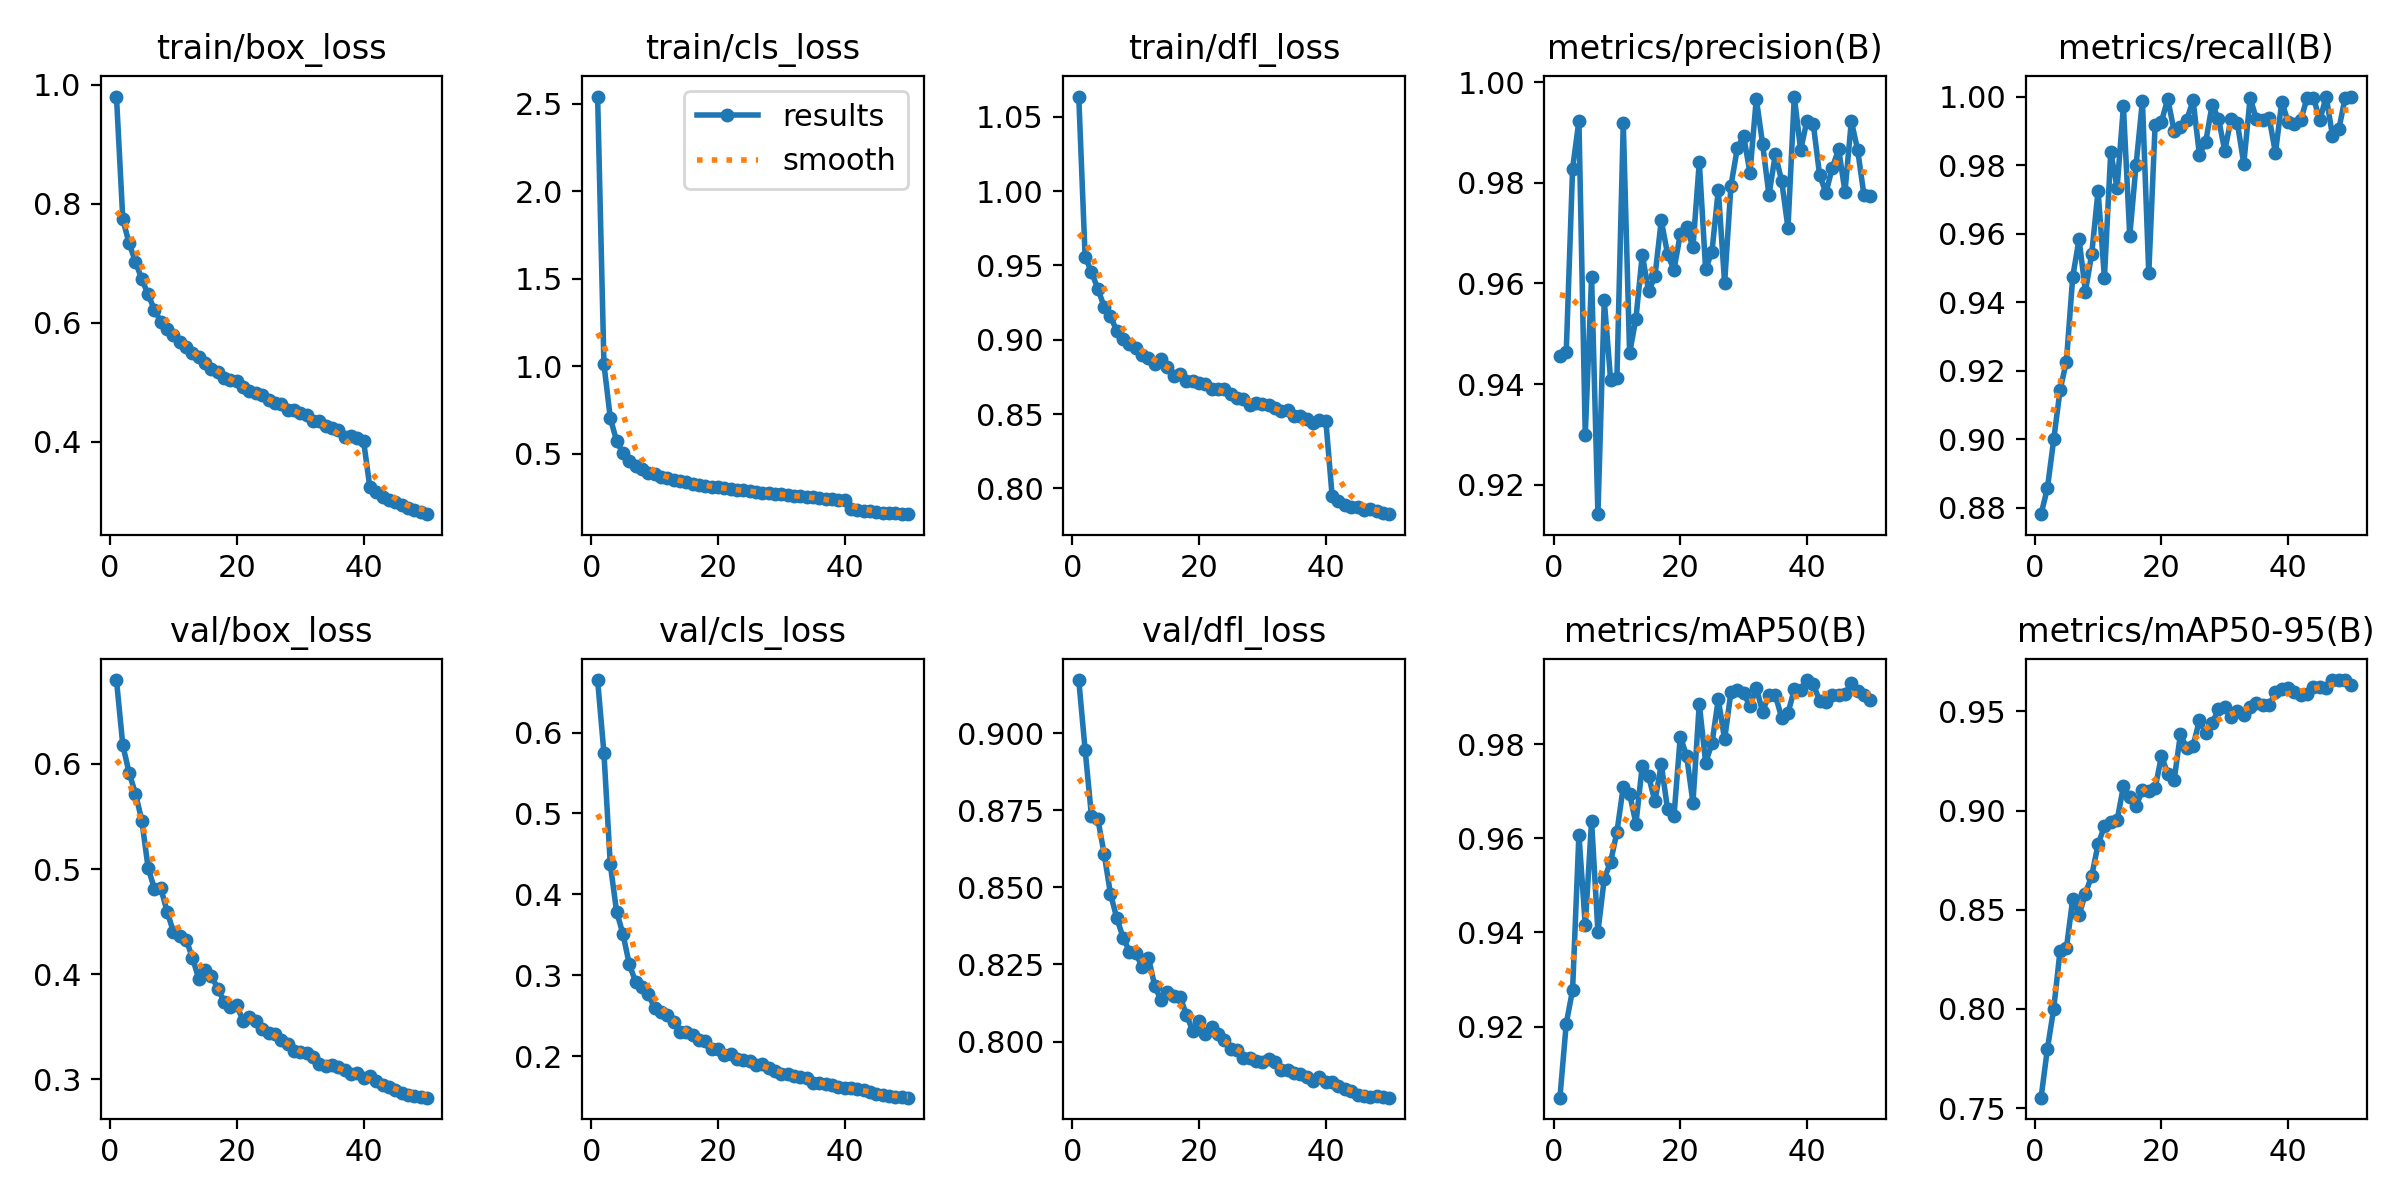

In [12]:
# @title **4.1 Plot YOLO result**

from google.colab import drive
from IPython.display import Image, display
import os

drive.mount('/content/drive')

# 1. Define where your results are (Based on your code)
drive_folder = '/content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs/run_safe_01'

# 2. Path to the results graph
results_img = os.path.join(drive_folder, 'results.png')

# 3. Check and Show
if os.path.exists(results_img):
    print("📈 Training Results (Loss & Accuracy):")
    display(Image(filename=results_img))
else:
    print(f"❌ Could not find results at: {results_img}")
    print("Check your Drive folder manually to ensure the training finished.")

# **5. YOLO Inference**

✅ Loading model from: /content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs/run_safe_01/weights/best.pt
🧪 Testing on: /content/yolo_dataset/val/images/05_0827.png

image 1/1 /content/yolo_dataset/val/images/05_0827.png: 480x640 1 Can, 241.3ms
Speed: 2.6ms preprocess, 241.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


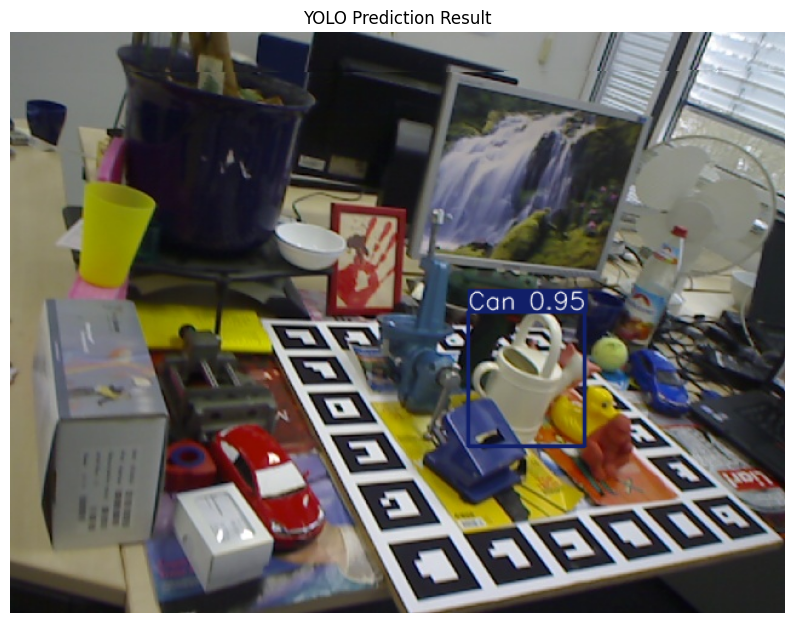

In [86]:
# @title **5.1 Reuse the model for inference**

from ultralytics import YOLO
import glob
import random
import cv2
import matplotlib.pyplot as plt

# 1. Load your TRAINED model from Drive
# We use 'best.pt' because it is the checkpoint with the highest accuracy
model_path = '/content/drive/MyDrive/AML/6d_pose_project/yolo_training_runs/run_safe_01/weights/best.pt'

if not os.path.exists(model_path):
    print("❌ Model not found! Check your Drive path.")
else:
    print(f"✅ Loading model from: {model_path}")
    model = YOLO(model_path)

    # 2. Pick a random image from your local validation dataset
    # (Assuming you ran the conversion step and have /content/yolo_dataset)
    val_images = glob.glob("/content/yolo_dataset/val/images/*.png")

    if len(val_images) > 0:
        test_img_path = random.choice(val_images)
        print(f"🧪 Testing on: {test_img_path}")

        # 3. Run Inference
        results = model.predict(test_img_path, conf=0.5) # conf=0.5 means "only show confident guesses"

        # 4. Show Result
        # YOLO's plot() returns a BGR numpy array
        result_plot = results[0].plot()

        # Convert to RGB for Matplotlib
        result_rgb = cv2.cvtColor(result_plot, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 8))
        plt.imshow(result_rgb)
        plt.axis('off')
        plt.title("YOLO Prediction Result")
        plt.show()
    else:
        print("⚠️ No validation images found in /content/yolo_dataset. Did you run the conversion step in this session?")
